**라이브러리 임포트**

In [6]:
import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.init as init
import math

from google.colab import drive

In [ ]:
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**모델 생성(학습된 파라미터 로드)**

In [7]:
class CompoundScaledResNet50(nn.Module):
  def __init__(self, width_mult=1.1, depth_mult=1.2, resolution_mult=1.15):
    super(CompoundScaledResNet50, self).__init__()
    self.base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    self.width_mult = width_mult
    self.depth_mult = depth_mult
    self.resolution_mult = resolution_mult

    self.input_resolution = int(224 * resolution_mult) # increase the resolution of images

    #self._modify_initial_layers()
    self._apply_width_scaling_to_bottlenecks()
    # self._modify_downsample_layers()
    self._apply_depth_scaling()

  def _apply_width_scaling_to_bottlenecks(self):
    for name, module in self.base_model.named_modules():
      if isinstance(module, models.resnet.Bottleneck):

        orig_conv2 = module.conv2 # middle layer of bottleneck

        scaled_channels = int(orig_conv2.out_channels * self.width_mult) # increase the channel of images

        new_conv1 = nn.Conv2d(
            in_channels = module.conv1.in_channels, # keep original input
            out_channels = scaled_channels,
            kernel_size = 1,
            stride = module.conv1.stride,
            bias = False
        )

        new_conv2 = nn.Conv2d(
            in_channels = scaled_channels,
            out_channels = scaled_channels,
            kernel_size = 3,
            stride = module.conv2.stride,
            padding = 1,
            bias = False
        )

        new_conv3 = nn.Conv2d(
            in_channels = scaled_channels,
            out_channels = module.conv3.out_channels,
            kernel_size = 1,
            bias = False
        )

        new_weight1 = torch.randn(scaled_channels, module.conv1.in_channels, 1, 1)
        new_weight2 = torch.randn(scaled_channels, scaled_channels, 3, 3)
        new_weight3 = torch.randn(module.conv3.out_channels, scaled_channels, 1, 1)

        init.kaiming_uniform_(new_weight1, a=math.sqrt(5))
        init.kaiming_uniform_(new_weight2, a=math.sqrt(5))
        init.kaiming_uniform_(new_weight3, a=math.sqrt(5))

        new_conv1.weight.data = new_weight1
        new_conv2.weight.data = new_weight2
        new_conv3.weight.data = new_weight3

        new_bn1 = nn.BatchNorm2d(scaled_channels)
        new_bn2 = nn.BatchNorm2d(scaled_channels)
        new_bn3 = nn.BatchNorm2d(module.conv3.out_channels)

        module.conv1 = new_conv1
        module.bn1 = new_bn1

        module.conv2 = new_conv2
        module.bn2 = new_bn2

        module.conv3 = new_conv3
        module.bn3 = new_bn3

  def _modify_downsample_layers(self):
    for name, module in self.base_model.named_modules():
      if isinstance(module, models.resnet.Bottleneck) and module.downsample is not None:
        conv1_in_channels = module.conv1.in_channels

        if hasattr(module, 'downsample'):
          module.downsample = nn.Sequential(
              nn.Conv2d(
                  in_channels = conv1_in_channels,
                  out_channels = module.downsample[0].out_channels,
                  kernel_size = 1,
                  stride = module.downsample[0].stride,
                  bias = False
              ),
              nn.BatchNorm2d(module.downsample[0].out_channels)
          )

  def _apply_depth_scaling(self):
    for name, child in self.base_model.named_children():
      if isinstance(child, nn.Sequential):
        new_depth = math.ceil(len(child) * self.depth_mult) # increase the depth

        if new_depth > len(child):
          additional_layers = [child[-1] for _ in range(new_depth - len(child))] # copy the last layer
          setattr(self.base_model, name, nn.Sequential(*list(child), *additional_layers)) # original seq + added layers

  def forward(self, x):
    x = nn.functional.interpolate(x, size=(self.input_resolution, self.input_resolution), mode='bilinear')
    return self.base_model(x)

In [10]:
class MyCompoundScaledResNet50(nn.Module):
  def __init__(self, width_mult=1.1, depth_mult=1.2, resolution_mult=1.0):
    super(MyCompoundScaledResNet50, self).__init__()

    self.backbone = CompoundScaledResNet50(
        width_mult=width_mult,
        depth_mult=depth_mult,
        resolution_mult=resolution_mult
    )

    # self.swish = nn.SiLU()
    self.dropout = nn.Dropout(0.3)
    self.extra_layer = nn.Linear(1000, 2)

  def forward(self, x):
    x = self.backbone(x)
    # x = self.swish(x)
    x = self.dropout(x)
    x = self.extra_layer(x)
    return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_resnet = MyCompoundScaledResNet50()
new_resnet.load_state_dict(torch.load('/content/drive/MyDrive/CAB/CAB_dataset/model/best_resnet_model.pth', map_location=torch.device('cpu')))
new_resnet.to(device);

<ipython-input-11-08ac4a26f17b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_resnet.load_state_dict(torch.load('/content/drive/MyDrive/CAB/CAB_dataset/model/best_res

**함수 정의**


주어진 좌표를 참고하여 이미지를 자른다.

In [12]:
def crop_image(image_path, coordinates):
    img = cv2.imread(image_path)

    x1, y1, x2, y2 = [int(coord) for coord in coordinates]
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

    return cropped_img

이미지를 변환한다.

In [13]:
def load_and_process_image(image):

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(30)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  transformed_image = transform(image)

  return transformed_image

모델이 예측을 수행하기 위한 함수이다. crop_image와 load_and_process_image 두 함수를 거친 이미지를 대상으로 예측을 수행한다.

In [14]:
def predict(model, image):

  close_or_open = ['Close', 'Open']

  model.eval()

  transformed_image = load_and_process_image(image)

  transformed_image = transformed_image.to(device).unsqueeze(0)

  with torch.no_grad():
    output = model(transformed_image)

  _, predicted_class = torch.max(output, 1)

  results = close_or_open[predicted_class]

  return results

예측하고자 하는 이미지를 확인하기 위한 함수이다.

In [15]:
def imshow(path):
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image, (3*width, 3*height), interpolation=cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

**예측 결과 확인**

예측하고자 하는 이미지이다. 눈과 입 모두 open 상태인 것을 알 수 있다.

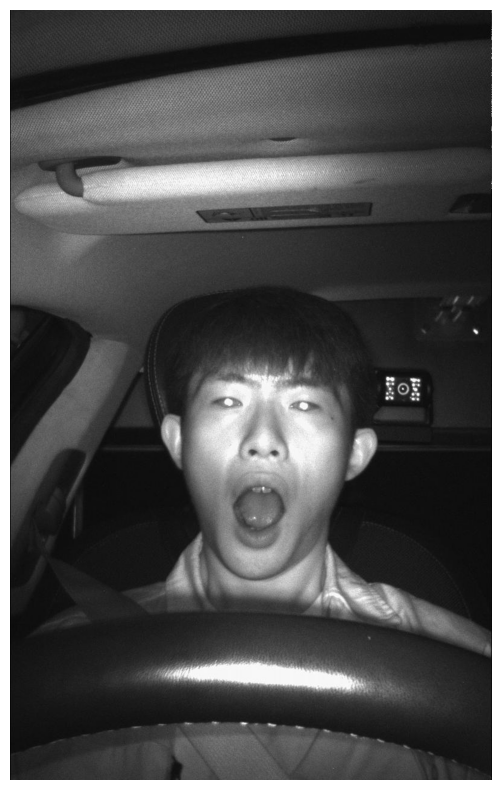

In [ ]:
#imshow("/content/drive/MyDrive/CAB/CAB_dataset/test_no_txt/045_G1_01_무광원_계기판_하품재현_20200929_110850_02512.jpg")

ResNet50 모델도 양쪽 눈과 입의 상태를 모두 open으로 맞게 예측하였다.

In [16]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path = "/content/drive/MyDrive/CAB/CAB_dataset/test_no_txt/045_G1_01_무광원_계기판_하품재현_20200929_110850_02512.jpg"

# leye = [319.0, 628.0, 406.0, 674.0]
# reye = [445.0, 635.0, 530.0, 684.0]
# mouth = [364.0, 770.0, 462.0, 891.0]

# if leye != [0, 0, 0, 0]:
#     leye_img = crop_image(path, leye)
#     predicted_leye = predict(new_resnet, leye_img)
# else:
#   predicted_leye = None

# if reye != [0, 0, 0, 0]:
#   reye_img = crop_image(path, reye)
#   predicted_reye = predict(new_resnet, reye_img)
# else:
#   predicted_reye = None

# if mouth != [0, 0, 0, 0]:
#   mouth_img = crop_image(path, mouth)
#   predicted_mouth = predict(new_resnet, mouth_img)
# else:
#     predicted_mouth = None

# print(f"Predicted [Left Eye, Right Eye, Mouth]: [{predicted_leye}, {predicted_reye}, {predicted_mouth}]")

Predicted [Left Eye, Right Eye, Mouth]: [Open, Open, Open]
